In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

def preprocess_dataset(file_path):
    processed_rows = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            columns = line.strip().split('\t')
            if len(columns) == 3:
                processed_rows.append(columns)

    df = pd.DataFrame(processed_rows, columns=['score', 'sentence1', 'sentence2'])
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df.dropna(subset=['score'], inplace=True)

    return df

train_df = preprocess_dataset('/content/drive/MyDrive/train.csv')
valid_df = preprocess_dataset('/content/drive/MyDrive/dev.csv')

class TextSimilarityDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence1 = self.data.iloc[index]['sentence1']
        sentence2 = self.data.iloc[index]['sentence2']
        label = self.data.iloc[index]['score']
        encoding = self.tokenizer(sentence1, sentence2, return_tensors='pt', padding='max_length', max_length=128, truncation=True)
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

class TextSimilarityModel(torch.nn.Module):
    def __init__(self, bert_model):
        super(TextSimilarityModel, self).__init__()
        self.bert = bert_model
        self.regressor = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs.pooler_output
        similarity_score = self.regressor(pooled_output)
        return similarity_score.squeeze()

model = TextSimilarityModel(bert_model)
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.MSELoss()

train_dataset = TextSimilarityDataset(train_df, tokenizer)
valid_dataset = TextSimilarityDataset(valid_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

model_save_path = '/content/drive/MyDrive/1a_checkpoints'
os.makedirs(model_save_path, exist_ok=True)

train_losses = []
valid_losses = []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch['input_ids'], batch['attention_mask'])
        loss = loss_fn(outputs, batch['labels'])
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_valid_loss = 0
    predictions, labels = [], []
    with torch.no_grad():
        for batch in valid_loader:
            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = loss_fn(outputs, batch['labels'])
            total_valid_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    pearson_corr, _ = pearsonr(predictions, labels)
    print(f'Epoch {epoch + 1}: Training Loss = {avg_train_loss}, Validation Loss = {avg_valid_loss}, Validation Pearson Correlation Coefficient: {pearson_corr}')

    checkpoint_path = os.path.join(model_save_path, f'model_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), checkpoint_path)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Training Loss = 1.0911039111911416, Validation Loss = 0.5960667468607426, Validation Pearson Correlation Coefficient: 0.8613920695406979
Epoch 2: Training Loss = 0.42434747590153826, Validation Loss = 0.6093427229510702, Validation Pearson Correlation Coefficient: 0.8757925609920884
Epoch 3: Training Loss = 0.22470038675335274, Validation Loss = 0.5568776318965398, Validation Pearson Correlation Coefficient: 0.8748488237968717
Epoch 4: Training Loss = 0.13847302840057374, Validation Loss = 0.6163070012369881, Validation Pearson Correlation Coefficient: 0.8694590223830543
Epoch 5: Training Loss = 0.10740855150446504, Validation Loss = 0.577765175829763, Validation Pearson Correlation Coefficient: 0.8689319970902898


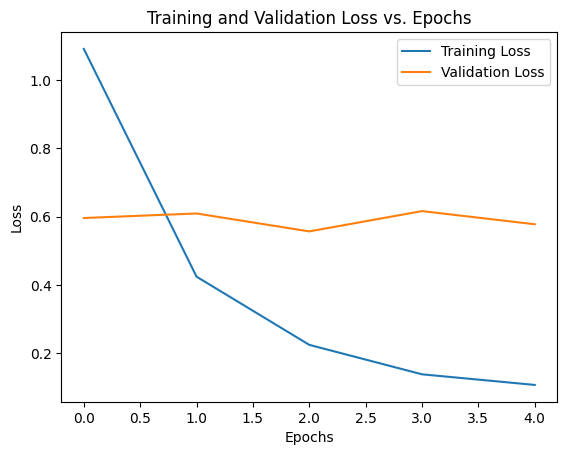

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss vs. Epochs')
plt.show()


FOR DEMO

In [4]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

class TextSimilarityDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)
    # 'setence' instead of sentence was written in the sample_test csv file
    def __getitem__(self, index):
        sentence1 = self.data.iloc[index]['setence1']
        sentence2 = self.data.iloc[index]['sentence2']
        encoding = self.tokenizer(sentence1, sentence2, return_tensors='pt', padding='max_length', max_length=128, truncation=True)
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

class TextSimilarityModel(torch.nn.Module):
    def __init__(self, bert_model):
        super(TextSimilarityModel, self).__init__()
        self.bert = bert_model
        self.regressor = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs.pooler_output
        similarity_score = self.regressor(pooled_output)
        return similarity_score.squeeze()

def load_model(model_path, device):
    model = TextSimilarityModel(bert_model)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict(model, test_data_loader, device):
    predictions = []
    with torch.no_grad():
        for batch in test_data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            predictions.extend(outputs.cpu().numpy())
    return predictions

def create_output_file(predictions, test_df, output_file_path):
    test_df['score'] = predictions
    test_df.to_csv(output_file_path, index=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = '/content/drive/MyDrive/1a_checkpoints/model_epoch_5.pth'
test_file_path = '/content/sample_test.csv'
output_file_path = '/content/sample_demo.csv'

bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_df = pd.read_csv(test_file_path, delimiter='\t')
test_dataset = TextSimilarityDataset(test_df, tokenizer)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = load_model(model_path, device)
predictions = predict(model, test_data_loader, device)
create_output_file(predictions, test_df, output_file_path)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]